In [3]:
import pickle
from IPython.display import display, clear_output
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
import pandas
import logging
from itertools import product as iterproduct, groupby, chain
import mltools
from multiprocessing import Pool
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/analysis_lib.ipynb"
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/context_lib.ipynb"
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/feature_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})
logger = logging.getLogger("log")
logger.setLevel(logging.INFO)

In [4]:
args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_100.alignment_true_events.pickle",
     "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/LomanLab_MAP-006/ecoli_mg1655.fa",
    "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1.model.computed.pickle",
    "ncores": 64
#     "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/ibislambda.model.pickle"
#     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
}

In [5]:
NMER = 6

In [6]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [7]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [8]:
HMM_PARAMS = pickle.load(open(args["model"], 'rb'))
HMM_PARAMS = HMM_PARAMS["/opt/chimaera/model/r7.3_e6_70bps_6mer/template_median68pA.model"]

In [9]:
ref = load_ref(args["ref"])

['>gi|556503834|ref|NC_000913.3| Escherichia coli str. K-12 substr. MG1655, complete genome']
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT


In [10]:
test_event = true_events[2000]
print(test_event['kmer'], _get_context(test_event, 0,6))
assert test_event['kmer'] == _get_context(test_event, 0, 6), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    _get_context(test_event, -20, 26))

CGCAGG CGCAGG


## Make Data

In [11]:
CONTEXT = (-10, 20)

In [12]:
all_kmers = mk_kmer_dict(NMER)
kmer_means = {kmer : float(HMM_PARAMS[HMM_PARAMS["kmer"] == kmer]["level_mean"]) for kmer in all_kmers}

In [13]:
template_events = [ev for ev in true_events if not np.isnan(ev["template.mean"])]
template_events = [ev for ev in template_events if 
               ev["ref_position"] > abs(CONTEXT[0]) and ev["ref_position"] < len(ref)-CONTEXT[1]-1]
template_events = np.array(template_events)

### Stratify

In [14]:
def stratify_events(events):
    """for each genomic position, only return the median event"""
    group_by = lambda x: x["ref_position"]
    sort_by = lambda x: x["template.mean"]
    events = sorted(events, key=group_by)
    events_strat = []
    for pos, group in groupby(events, key=group_by):
        group = list(group)
        group = sorted(group, key=sort_by)
        events_strat.append(group[int(len(group)/2)])
    return events_strat

In [15]:
events_strat = stratify_events(template_events)
len(events_strat), len(template_events), len(events_strat)/len(template_events)

(177924, 216348, 0.8223972488768095)

### Analyse

In [16]:
def dwelltime(ev):
    return ev["template.length"] 

def mean_diff(ev): 
    return ev["template.mean"] - kmer_means[ev["kmer"]]

def ev_stdv(ev):
    return ev["template.stdv"]

In [17]:
def analyse_feat(target_function, plot=False):
    values = [target_function(ev) for ev in template_events]
    if plot:
        sns.distplot(values, label=str(target_function))
        legend()
    return np.percentile(values, 1), np.percentile(values, 99)
    
    

In [18]:
mean([abs(mean_diff(ev)) for ev in template_events])

0.75165734272637852

In [19]:
quantile_diff = analyse_feat(mean_diff)
quantile_diff

(-2.8495201330184319, 2.8556196116705381)

In [20]:
quantile_dwell = analyse_feat(dwelltime)
quantile_dwell

(0.0029880478087649402, 0.12284196547144755)

In [21]:
quantile_stdv = analyse_feat(ev_stdv)
quantile_stdv

(0.40073177992794412, 2.6375458797784583)

### Filter
remove outliers

In [22]:
def filter_event_ids(event_ids, all_events):
    fevent_ids = event_ids[:]
    fevent_ids = [evid for evid in  fevent_ids
                       if quantile_diff[0] <= mean_diff(all_events[evid]) <= quantile_diff[1]]
    fevent_ids = [evid for evid in fevent_ids 
                       if quantile_dwell[0] <= dwelltime(all_events[evid]) <= quantile_dwell[1]]
    fevent_ids = [evid for evid in fevent_ids 
                       if ev_stdv(all_events[evid]) <= quantile_stdv[1]]
    logger.info("events removed: {0}".format(abs(len(fevent_ids) - len(event_ids))))
    return fevent_ids


### prepare

In [23]:
def make_target(ev): 
    return ev["template.mean"] - kmer_means[ev["kmer"]]

In [47]:
def make_features(event):
    context = _get_context(event, -20, 26)
    assert event["kmer"] == context[20:26]
    return mk_feature_all(event["template.mean"], event["template.stdv"], _get_context(event, -20, 26))

In [48]:
def make_data(events):    
    p = Pool(args["ncores"])
    print("mk features: ")
    results = []
#     results = [mk_features_manual(e) for e in events]
    try:
        for i, res in enumerate(p.imap_unordered(make_features, events, chunksize=200), 1):
            results.append(res)
            sys.stdout.write('\rdone {0:%}'.format(i/float(len(events))))
        p.close()
        p.join()
    except KeyboardInterrupt:
        p.terminate()
    features = np.array(postprocess_features(results))
    target = np.array([make_target(ev) for ev in events])
    return features, target

In [49]:
features, target = make_data(events_strat)

mk features: 
done 100.000000%

In [30]:
k = 3

In [31]:
features[k]

array([ 0.15905366,  0.03193901,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.  

# Target reference plots

In [32]:
np.mean([abs(x) for x in target])

0.71082873662821955

In [33]:
np.mean([abs(x)**2 for x in target])

0.9907398047580569

(-5, 5)

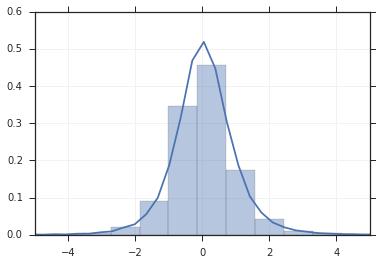

In [34]:
fig, ax = subplots()
sns.distplot(target, ax=ax)
ax.set_xlim(-5,5)

## Machine Learning

In [35]:
from sklearn import svm
from sklearn import neural_network
from sklearn.cross_validation import KFold
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics as skmetrics
from scipy import stats
import sklearn

In [36]:
fs = sklearn.feature_selection.SelectKBest(k=25)

In [37]:
len(features)

177924

In [38]:
[x for x in enumerate(features[0])]

[(0, 0.62410275654553204),
 (1, 0.062346604103793828),
 (2, 0.0),
 (3, 0.0),
 (4, 1.0),
 (5, 0.0),
 (6, 0.0),
 (7, 1.0),
 (8, 0.0),
 (9, 0.0),
 (10, 1.0),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.0),
 (15, 0.0),
 (16, 0.0),
 (17, 1.0),
 (18, 0.0),
 (19, 0.0),
 (20, 0.0),
 (21, 1.0),
 (22, 1.0),
 (23, 0.0),
 (24, 0.0),
 (25, 0.0),
 (26, 1.0),
 (27, 0.0),
 (28, 0.0),
 (29, 0.0),
 (30, 0.0),
 (31, 1.0),
 (32, 0.0),
 (33, 0.0),
 (34, 0.0),
 (35, 0.0),
 (36, 1.0),
 (37, 0.0),
 (38, 0.0),
 (39, 1.0),
 (40, 0.0),
 (41, 0.0),
 (42, 0.0),
 (43, 1.0),
 (44, 0.0),
 (45, 0.0),
 (46, 1.0),
 (47, 0.0),
 (48, 0.0),
 (49, 0.0),
 (50, 1.0),
 (51, 0.0),
 (52, 0.0),
 (53, 0.0),
 (54, 0.0),
 (55, 1.0),
 (56, 0.0),
 (57, 0.0),
 (58, 0.0),
 (59, 1.0),
 (60, 0.0),
 (61, 0.0),
 (62, 0.0),
 (63, 1.0),
 (64, 0.0),
 (65, 0.0),
 (66, 0.0),
 (67, 0.0),
 (68, 1.0),
 (69, 0.0),
 (70, 1.0),
 (71, 0.0),
 (72, 0.0),
 (73, 0.0),
 (74, 1.0),
 (75, 0.0),
 (76, 0.0),
 (77, 0.0),
 (78, 1.0),
 (79, 0.0),
 (80, 0.0),
 (81,

In [40]:
reg = svm.LinearSVR()
reg = ensemble.RandomForestRegressor(n_estimators=25, n_jobs=-1)
# reg = svm.SVR()
kf = KFold(len(features), n_folds=3)

INFO:log:events removed: 2770
INFO:log:events removed: 2135
INFO:log:events removed: 2347


{'mae': 0.62235717115026157,
 'mse': 0.77786099792701069,
 'pearson': 0.46160232205013124}

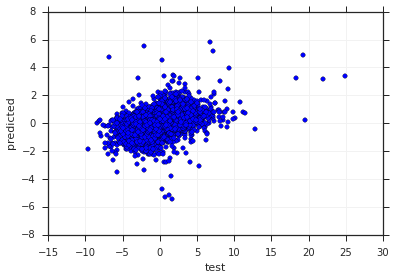

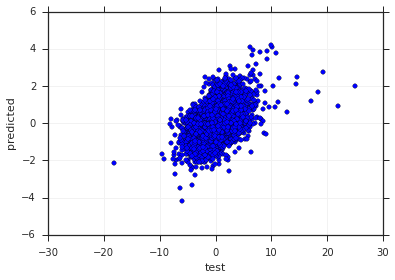

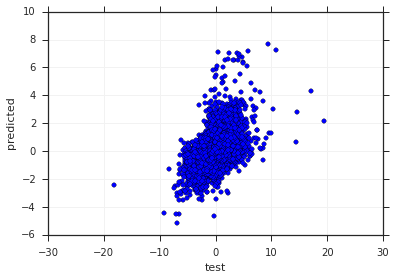

In [51]:
metrics = {
    "pearson": lambda x,y: stats.pearsonr(x,y)[0],
    "mae": skmetrics.mean_absolute_error,
    "mse": skmetrics.mean_squared_error
}
metrics_result = {m: [] for m in metrics}
for test, train in kf: 
    train = filter_event_ids(train, template_events)
    f_train, f_test = features[train], features[test]
    t_train, t_test = target[train], target[test]
    reg.fit(f_train, t_train)
    t_predicted= reg.predict(f_test)
    for m, f in metrics.items(): 
        metrics_result[m].append(f(t_test, t_predicted))
    figure()
    scatter(t_test, t_predicted)
    xlabel("test")
    ylabel("predicted")

{m: mean(v) for (m, v) in metrics_result.items()}

In [42]:
reg.fit(features, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [43]:
import joblib

In [46]:
joblib.dump(reg, '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/models/model-test2.pickle', protocol=2)

['/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/models/model-test2.pickle',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/models/model-test2.pickle_01.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/models/model-test2.pickle_02.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/models/model-test2.pickle_03.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/models/model-test2.pickle_04.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/models/model-test2.pickle_05.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/models/model-test2.pickle_06.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/models/model-test2.pickle_07.npy',
 '/home/ibis/gr